In [1]:
import pandas as pd
import numpy as np
# load libraries  45.03423447058859 42.58356449833813

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import optuna

In [ ]:
#data
train=pd.read_csv("dataset/train_features.csv")
y=pd.read_csv("dataset/train_labels.csv")
test=pd.read_csv("dataset/test_features.csv")
ss=pd.read_csv("dataset/submission_format.csv")
test_ground_truth=pd.read_csv("dataset/sdoh_test_labels.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

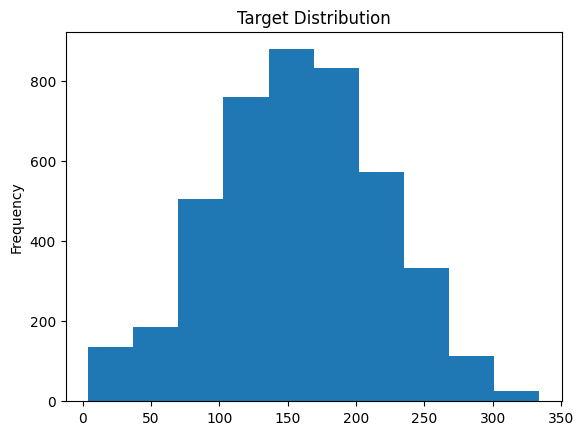

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [12]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

In [13]:
def get_cat_cols(data):
    # Get the columns with object datatype
    cat_columns=[]
    dummies=[]
    for col in data.columns:
        if data[col].dtype=='object' and 'uid' not in col:
            cat_columns.append(col)
            dummies.append(col)
        elif data[col].dtype!='object' and 'uid' not in col and (data[col].max()==1.0):
            cat_columns.append(col)
            data[col].fillna(0, inplace=True)
        else:
            continue
    return cat_columns, dummies

In [14]:
def encode_cat_cols(train_data, cat_cols, dummy_cols):
    enc = OneHotEncoder()
    enc.fit(train_data[dummy_cols])
    encoded_train_data=enc.transform(train_data[dummy_cols]).toarray()
    feature_names = enc.get_feature_names_out(dummy_cols)
    train_data.drop(columns=dummy_cols, inplace=True)
    encoded_train_df = pd.DataFrame(encoded_train_data, columns=feature_names)
    train_data[feature_names]=encoded_train_df[feature_names]
    return train_data, feature_names

In [15]:
y=merged_df['composite_score']
data_processed=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data_processed = feature_engineering(data_processed)
cat_cols, dummy_cols = get_cat_cols(data_processed)
data_processed, dummy_feature_names=encode_cat_cols(data_processed, cat_cols, dummy_cols)
data_processed=data_processed.drop(columns=['composite_score'],axis=1)

for col in data_processed.columns: 
    if round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>50:
        data_processed.drop(columns=col, inplace=True)
    elif round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>5:
        print(col,round((data_processed[col].isna().sum() /len(data_processed)*100), 2), '% missing')
        data_processed[col].fillna(0, inplace=True)
    else: 
        data_processed[col].fillna(0, inplace=True)
        data_processed[col].fillna(0, inplace=True)

/tmp/ipykernel_2994495/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_2994495/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_2994495/2658724754.py:13: FutureWarning: Downcasting behavior i

n_mar_03 33.83 % missing
edu_gru_03 33.55 % missing
glob_hlth_03 36.99 % missing
n_adl_03 33.5 % missing
n_iadl_03 36.99 % missing
n_depr_03 37.1 % missing
n_illnesses_03 33.31 % missing
decis_personal_03 37.17 % missing
glob_hlth_12 5.8 % missing
n_iadl_12 5.84 % missing
n_depr_12 6.52 % missing
bmi_12 12.48 % missing
memory_12 6.72 % missing
rearnings_03 33.37 % missing
searnings_03 49.98 % missing
hincome_03 34.01 % missing
hinc_business_03 32.98 % missing
hinc_rent_03 32.98 % missing
hinc_assets_03 32.98 % missing
hinc_cap_03 32.98 % missing
rinc_pension_03 33.37 % missing
sinc_pension_03 49.98 % missing
searnings_12 35.19 % missing
sinc_pension_12 35.19 % missing
hincome_change 37.28 % missing
niadl_change 41.13 % missing
adl_change 36.4 % missing
depr_change 41.65 % missing
glob_hlth_change 41.1 % missing
edu_gru_change 36.09 % missing
illnesses_change 36.29 % missing


/tmp/ipykernel_2994495/3102208485.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[col].fillna(0, inplace=True)
/tmp/ipykernel_2994495/3102208485.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [16]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

/tmp/ipykernel_2994495/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_2994495/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_2994495/2658724754.py:13: FutureWarning: Downcasting behavior i

In [17]:
#separate train and test
merged_df_processed=data_processed[:len(merged_df)]
merged_test_processed=data_processed[len(merged_df):]

In [18]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [19]:
merged_df.shape

(4343, 196)

In [20]:
merged_df_processed.shape

(4343, 349)

In [ ]:
# Running this code cell takes a long time. I already ran it and saved the best parameters for each model in the next cell

"""# Define an objective function for Optuna for each model
def objective_lightgbm(trial, train_X, train_y, val_X, val_y):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        "random_state": 42,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 50.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 50.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)
    }

    train_data = lgb.Dataset(train_X, label=train_y)
    val_data = lgb.Dataset(val_X, label=val_y, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=params['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=False),
        ]
    )

    preds = model.predict(val_X, num_iteration=model.best_iteration)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_catboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'depth': trial.suggest_int('depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'iterations': trial.suggest_int('iterations', 50, 5000)
    }

    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=0, early_stopping_rounds = 500,
        random_state=42
    )
    model.fit(train_X, train_y, eval_set=(val_X, val_y))

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_xgboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 50.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 50.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)
    }

    model = XGBRegressor(**params,
                         enable_categorical=True,
                         eval_metric=root_mean_squared_error,
                         early_stopping_rounds=500,
                         random_state=42)
    model.fit(
        train_X, train_y,
        eval_set=[(val_X, val_y)],
        verbose=False,
    )

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_randomforest(trial, train_X, train_y, val_X, val_y):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 50, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000)
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(train_X, train_y)

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

# Run Optuna for each model and store the best parameters
best_params = {}
for model_name, objective in zip(
    ['lightgbm', 'RandomForest', 'XGBoost', 'CatBoost'],
    [objective_lightgbm, objective_randomforest, objective_xgboost, objective_catboost]
):
    study = optuna.create_study(direction='minimize')
    if model_name == 'RandomForest':
        unique_uids = merged_df_processed['uid'].unique()
        train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=42)
        keep_train = merged_df_processed['uid'].isin(train_ids)
        keep_val = merged_df_processed['uid'].isin(val_ids)
        train_X, val_X = merged_df_processed[keep_train],merged_df_processed[keep_val]
        train_X.drop(columns=['uid'], inplace=True)
        val_X.drop(columns=['uid'], inplace=True)
        train_y, val_y= y[keep_train], y[keep_val]
        # train_X, val_X, train_y, val_y = train_test_split(merged_df_processed, y, test_size=0.2, random_state=42)
    else:
        unique_uids = merged_df['uid'].unique()
        train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=42)
        keep_train = merged_df['uid'].isin(train_ids)
        keep_val = merged_df['uid'].isin(val_ids)
        train_X, val_X = merged_df[keep_train],merged_df[keep_val]
        train_X.drop(columns=['uid'], inplace=True)
        val_X.drop(columns=['uid'], inplace=True)
        train_y, val_y= y[keep_train], y[keep_val]
        # train_X, val_X, train_y, val_y = train_test_split(merged_df, y, test_size=0.2, random_state=42)
    study.optimize(lambda trial: objective(trial, train_X, train_y, val_X, val_y), n_trials=100, n_jobs=-1, show_progress_bar=True)
    best_params[model_name] = study.best_params
    print(f"Best params for {model_name}: {study.best_params}")
    print(f"Best RMSE for {model_name}: {study.best_value}")
    
"""

In [ ]:
# best_params

{'lightgbm': {'learning_rate': 0.07089438962267576,
  'num_leaves': 49,
  'max_depth': 4,
  'feature_fraction': 0.4839642718097913,
  'bagging_fraction': 0.5497799156909652,
  'lambda_l1': 0.058207015936292725,
  'lambda_l2': 0.08350139961819975,
  'min_child_samples': 85,
  'n_estimators': 4077},
 'RandomForest': {'max_depth': 30,
  'min_samples_split': 22,
  'min_samples_leaf': 6,
  'max_features': 0.8191960808589205,
  'n_estimators': 97},
 'XGBoost': {'learning_rate': 0.033763045458285304,
  'max_depth': 3,
  'min_child_weight': 14,
  'subsample': 0.9500263286639197,
  'colsample_bytree': 0.7747635615654157,
  'gamma': 7.558507636378349,
  'reg_alpha': 0.4378783168336932,
  'reg_lambda': 2.8408676886824322,
  'n_estimators': 2804},
 'CatBoost': {'depth': 6,
  'learning_rate': 0.025804617832891515,
  'l2_leaf_reg': 0.22567510948252656,
  'random_strength': 1.8064759944089426,
  'bagging_temperature': 0.4675254776654324,
  'iterations': 1224}}

In [21]:
best_params = {'lightgbm': {'learning_rate': 0.07089438962267576,
  'num_leaves': 49,
  'max_depth': 4,
  'feature_fraction': 0.4839642718097913,
  'bagging_fraction': 0.5497799156909652,
  'lambda_l1': 0.058207015936292725,
  'lambda_l2': 0.08350139961819975,
  'min_child_samples': 85,
  'n_estimators': 4077},
 'RandomForest': {'max_depth': 30,
  'min_samples_split': 22,
  'min_samples_leaf': 6,
  'max_features': 0.8191960808589205,
  'n_estimators': 97},
 'XGBoost': {'learning_rate': 0.033763045458285304,
  'max_depth': 3,
  'min_child_weight': 14,
  'subsample': 0.9500263286639197,
  'colsample_bytree': 0.7747635615654157,
  'gamma': 7.558507636378349,
  'reg_alpha': 0.4378783168336932,
  'reg_lambda': 2.8408676886824322,
  'n_estimators': 2804},
 'CatBoost': {'depth': 6,
  'learning_rate': 0.025804617832891515,
  'l2_leaf_reg': 0.22567510948252656,
  'random_strength': 1.8064759944089426,
  'bagging_temperature': 0.4675254776654324,
  'iterations': 1224}}

In [ ]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []
unique_uids = merged_df['uid'].unique()  # Extract unique uids

for train_ids, val_ids in tqdm(KFold(n_splits=5, shuffle=True, random_state=42).split(unique_uids)):
    # Split the data
    train_uids, val_uids = unique_uids[train_ids], unique_uids[val_ids]
    keep_train = merged_df['uid'].isin(train_uids)
    keep_val = merged_df['uid'].isin(val_uids)
    
    train_X, val_X = merged_df[keep_train], merged_df[keep_val]
    train_X.drop(columns=['uid'], inplace=True)
    val_X.drop(columns=['uid'], inplace=True)
    train_y, val_y = y[keep_train], y[keep_val]
    
    train_X_processed, val_X_processed = merged_df_processed[keep_train], merged_df_processed[keep_val]
    train_X_processed.drop(columns=['uid'], inplace=True)
    val_X_processed.drop(columns=['uid'], inplace=True)

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')
        
    best_params['lightgbm']['objective'] = 'regression'
    best_params['lightgbm']['metric'] = 'rmse'
    best_params['lightgbm']['random_state'] = 42

    # Train the model with early stopping
    model1 = lgb.train(
        best_params['lightgbm'],
        train_data,
        valid_sets=[val_data],
        num_boost_round=best_params['lightgbm']['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        **best_params['CatBoost'],
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500,
        random_state=42
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(
        **best_params['XGBoost'],
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500,
        random_state=42)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)
    
    # Train Random Forest
    model4 = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
    model4.fit(train_X_processed, train_y)
    pred4 = model4.predict(val_X_processed)
    print("RandomForest rmse: ", root_mean_squared_error(val_y, pred4))

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3, w4 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3 + w4 * pred4
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/4, 1/4, 1/4, 1/4]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] + w[3] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3 +
        optimized_weights[3] * pred4
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


In [23]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 40.157203856294316


In [25]:
np.mean(optimized_weights_list, axis=0)

array([0.25985829, 0.38508924, 0.21887303, 0.13617944])

In [ ]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
merged_df.drop(columns=['uid'], inplace=True)
merged_test.drop(columns=['uid'], inplace=True)
merged_df_processed.drop(columns=['uid'], inplace=True)
merged_test_processed.drop(columns=['uid'], inplace=True)
train_data = lgb.Dataset(merged_df, label=y, categorical_feature='auto')

best_params['lightgbm']['objective'] = 'regression'
best_params['lightgbm']['metric'] = 'rmse'
best_params['lightgbm']['random_state'] = 42

final_model1 = lgb.train(
    best_params['lightgbm'],
    train_data,
    num_boost_round=best_params['lightgbm']['n_estimators']
)

final_model2 = CatBoostRegressor(
    **best_params['CatBoost'],
    loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    random_state=42
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(
    **best_params['XGBoost'],
    enable_categorical=True,
    eval_metric=root_mean_squared_error,
    random_state=42)
final_model3.fit(merged_df, y)

# Train Random Forest
final_model4 = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
final_model4.fit(merged_df_processed, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)
test_pred4 = final_model4.predict(merged_test_processed)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3 + average_weights[3] * test_pred4
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('dataset/Final.csv', index=False)

In [30]:
# mean squared error on test set
root_mean_squared_error(test_ground_truth['composite_score'], ss['composite_score'])

39.23915534535873